In [1]:
from typing import Tuple, Dict, Any
import nptyping
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow.keras.backend as K
import tensorflow.keras.layers

from smot.training import kaggle_data

/home/crutcher/git/smot/venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210204). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:
# PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
# PassengerId: int - id of passenger.
# Survived: { 0, 1 } - (the label) did the passenger survive?
# Pclass: { 1, 2, 3 } - the class of the passenger's ticket.
# Sex: { "male", "female" } - the gender of the passenger.
# Name: str - the name of the passenger.
# Age: float - the age in years of the passenger; < 1 for babies; fractional (xx.5) if estimated.
# SibSp: int - # of siblings or spouses aboard.
# Parch: int - # of parents or children aboard.
# Ticket: int - the ticket number.
# Fare: float - the ticket price.
# Cabin: int - the cabin assignment.
# Embarked: { C, Q, S } - the port of embarkation.
titanic_train_df = pd.read_csv(kaggle_data.kaggle_data_path("titanic", "train.csv"))
titanic_test_df = pd.read_csv(kaggle_data.kaggle_data_path("titanic", "test.csv"))

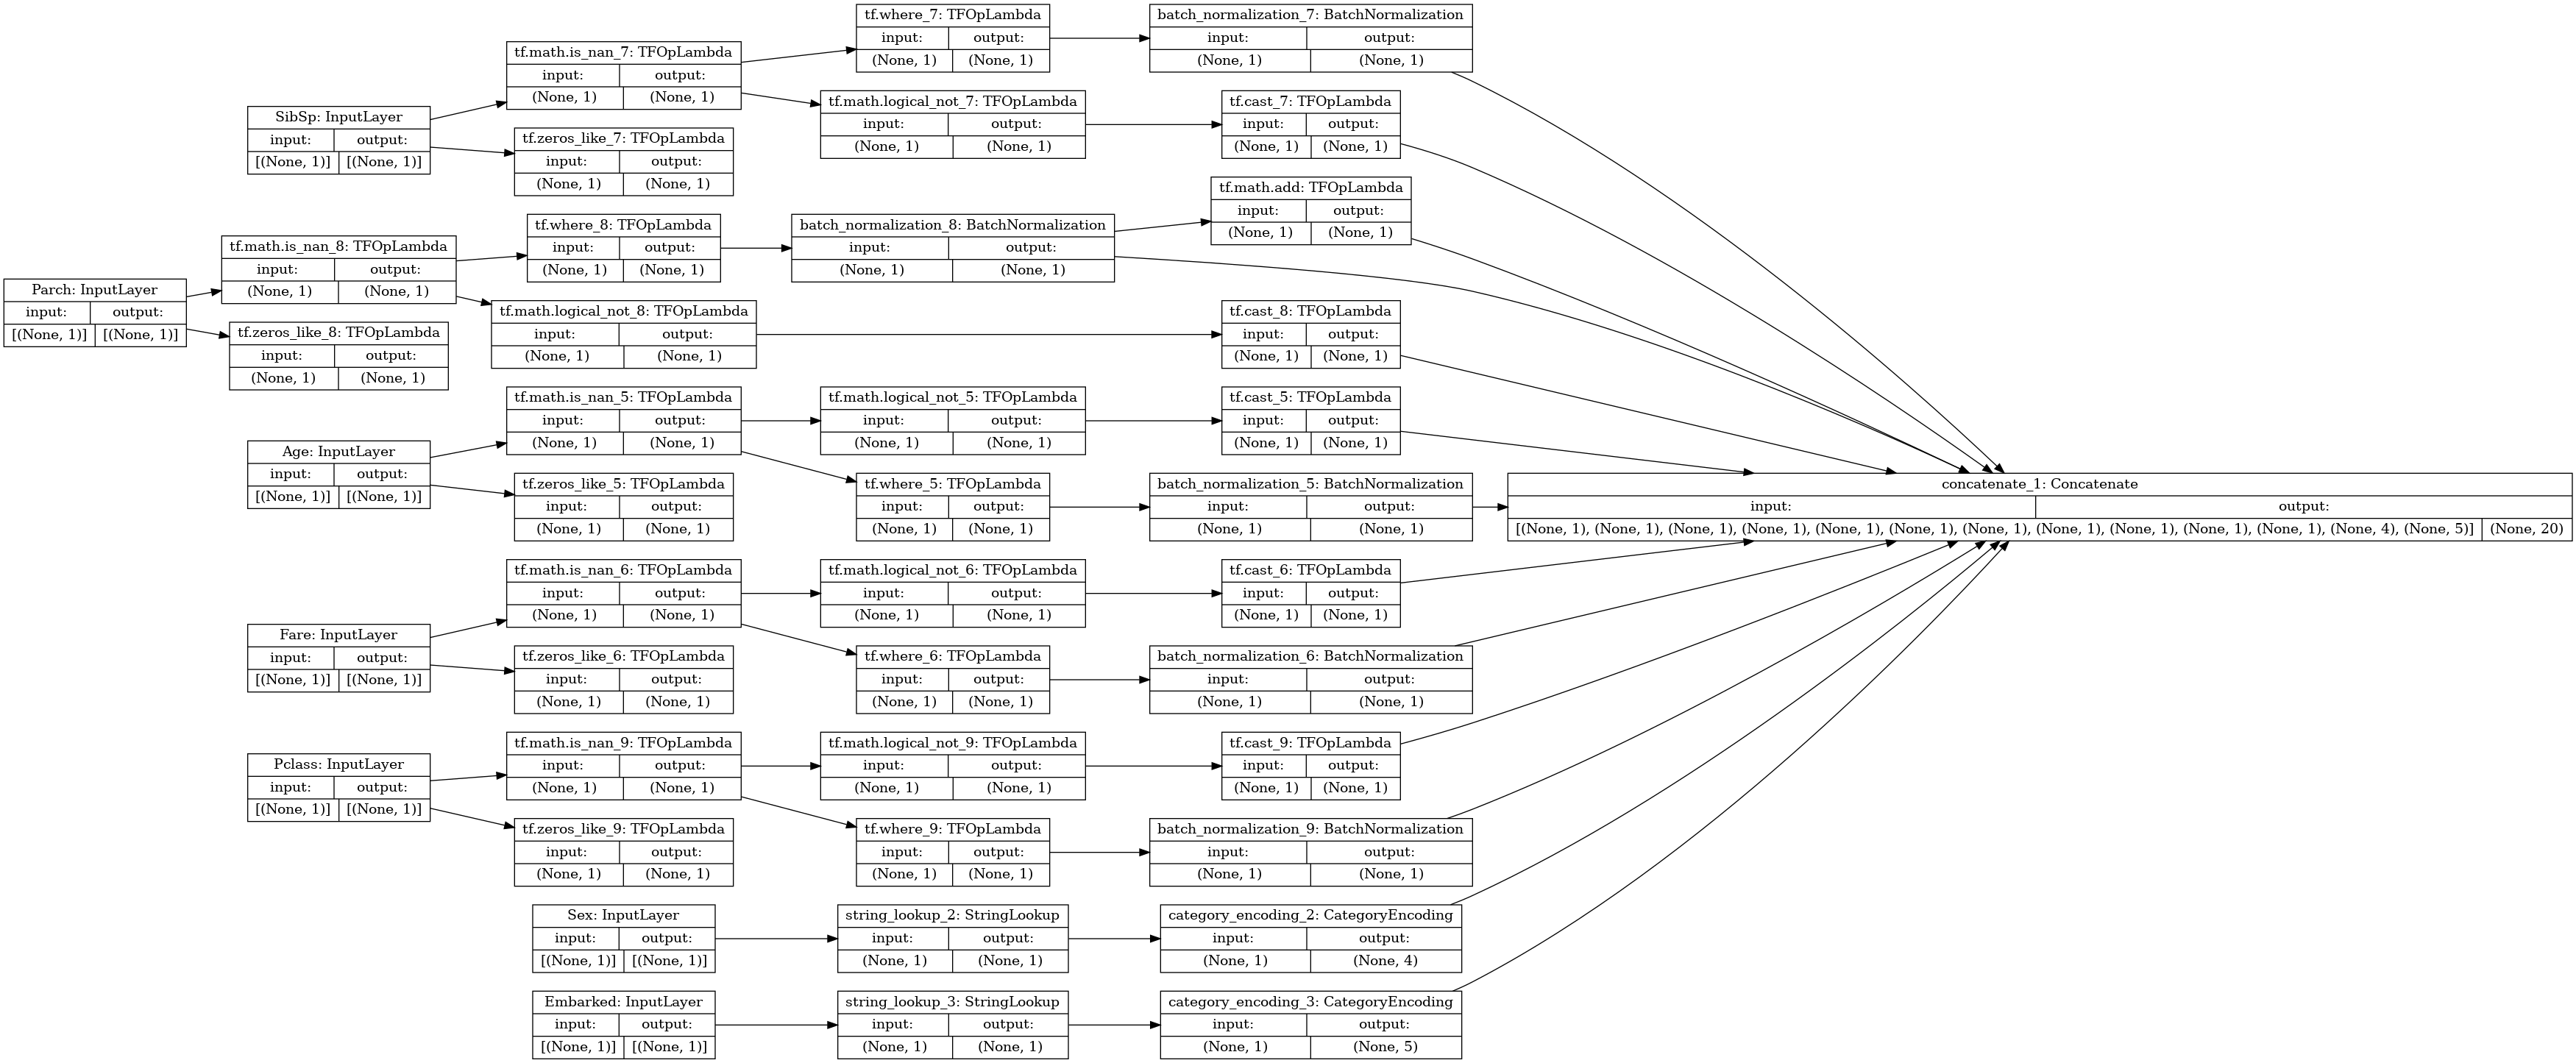

In [9]:
# id, survived, age, class (1-hot), sex (1-hot)


def extract_titanic_features(
    source: pd.DataFrame,
) -> Dict[str, nptyping.NDArray[(Any,)]]:
    """
    Extract a Titanic problem dataset.
    """
    # Adapt the dataframe values to numpy.
    features = {
        name: np.array(value, np.float32)
        for name, value in source[["Age", "Fare", "SibSp", "Parch", "Pclass"]].items()
    }

    features["Sex"] = np.array(source["Sex"], np.str)
    features["Embarked"] = np.array(source["Embarked"], np.str)

    return features


train_labels = titanic_train_df["Survived"]
train_features = extract_titanic_features(titanic_train_df)

test_features = extract_titanic_features(titanic_test_df)

inputs = {
    k: tf.keras.Input(shape=(1,), name=k, dtype=v.dtype)
    for k, v in train_features.items()
}
preprocessed_inputs = []

numeric_inputs = {k: v for k, v in inputs.items() if v.dtype == tf.float32}


def nan_mask(
    layer: tf.keras.layers.Layer,
) -> Tuple[tf.keras.layers.Layer, tf.keras.layers.Layer]:
    """
    Build a mask for a nan-able numeric layer.

    Given a NaN-able numeric layer, yield a (is_not_nan {0, 1} mask, and a

    :param layer: the layer to mask.
    :return: a (mask, nanless-value) tuple.
    """
    is_nan = tf.math.is_nan(layer)

    finite_input = tf.where(is_nan, tf.zeros_like(layer), layer)

    norm_input = tf.keras.layers.BatchNormalization()(finite_input)

    mask = tf.cast(tf.math.logical_not(is_nan), tf.float32)
    return mask, norm_input


finite_numeric_inputs = {}
numeric_masks = {}

for k, v in numeric_inputs.items():
    mask_v, finite_v = nan_mask(v)

    preprocessed_inputs.append(mask_v)
    preprocessed_inputs.append(finite_v)

    finite_numeric_inputs[k] = finite_v
    numeric_masks[k] = mask_v

accomp_count = tf.math.add(
    finite_numeric_inputs["Parch"], finite_numeric_inputs["SibSp"]
)
preprocessed_inputs.append(accomp_count)


gender_vocab = np.unique(train_features["Sex"])
gender_lookup = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=gender_vocab
)
gender_onehot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
    max_tokens=gender_lookup.vocab_size()
)
gender_input = gender_onehot(gender_lookup(inputs["Sex"]))
preprocessed_inputs.append(gender_input)

embarked_vocab = np.array(("C", "Q", "S"))
embarked_lookup = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=embarked_vocab
)
embarked_onehot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
    max_tokens=embarked_lookup.vocab_size()
)
embarked_input = embarked_onehot(embarked_lookup(inputs["Embarked"]))
preprocessed_inputs.append(embarked_input)

# x = tf.keras.layers.Concatenate()(list(finite_numeric_inputs))
# norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
# norm_layer.adapt(train_features[numeric_inputs.keys()])
# normalized_numeric_inputs = norm_layer(x)


# preprocessed_inputs.append(normalized_numeric_inputs)

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocess_model = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(
    preprocess_model,
    to_file="preprocess_model.png",
    rankdir="LR",
    show_shapes=True,
    show_layer_names=True,
)

In [10]:
processed_data = preprocess_model(train_features)
processed_data

<tf.Tensor: shape=(891, 20), dtype=float32, numpy=
array([[ 1.      , 21.989008,  1.      , ...,  0.      ,  0.      ,
         1.      ],
       [ 1.      , 37.981014,  1.      , ...,  1.      ,  0.      ,
         0.      ],
       [ 1.      , 25.98701 ,  1.      , ...,  0.      ,  0.      ,
         1.      ],
       ...,
       [ 0.      ,  0.      ,  1.      , ...,  0.      ,  0.      ,
         1.      ],
       [ 1.      , 25.98701 ,  1.      , ...,  1.      ,  0.      ,
         0.      ],
       [ 1.      , 31.98401 ,  1.      , ...,  0.      ,  1.      ,
         0.      ]], dtype=float32)>

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embarked (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Fare (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Parch (InputLayer)              [(None, 1)]          0                                            
____________________________________________________________________________________________

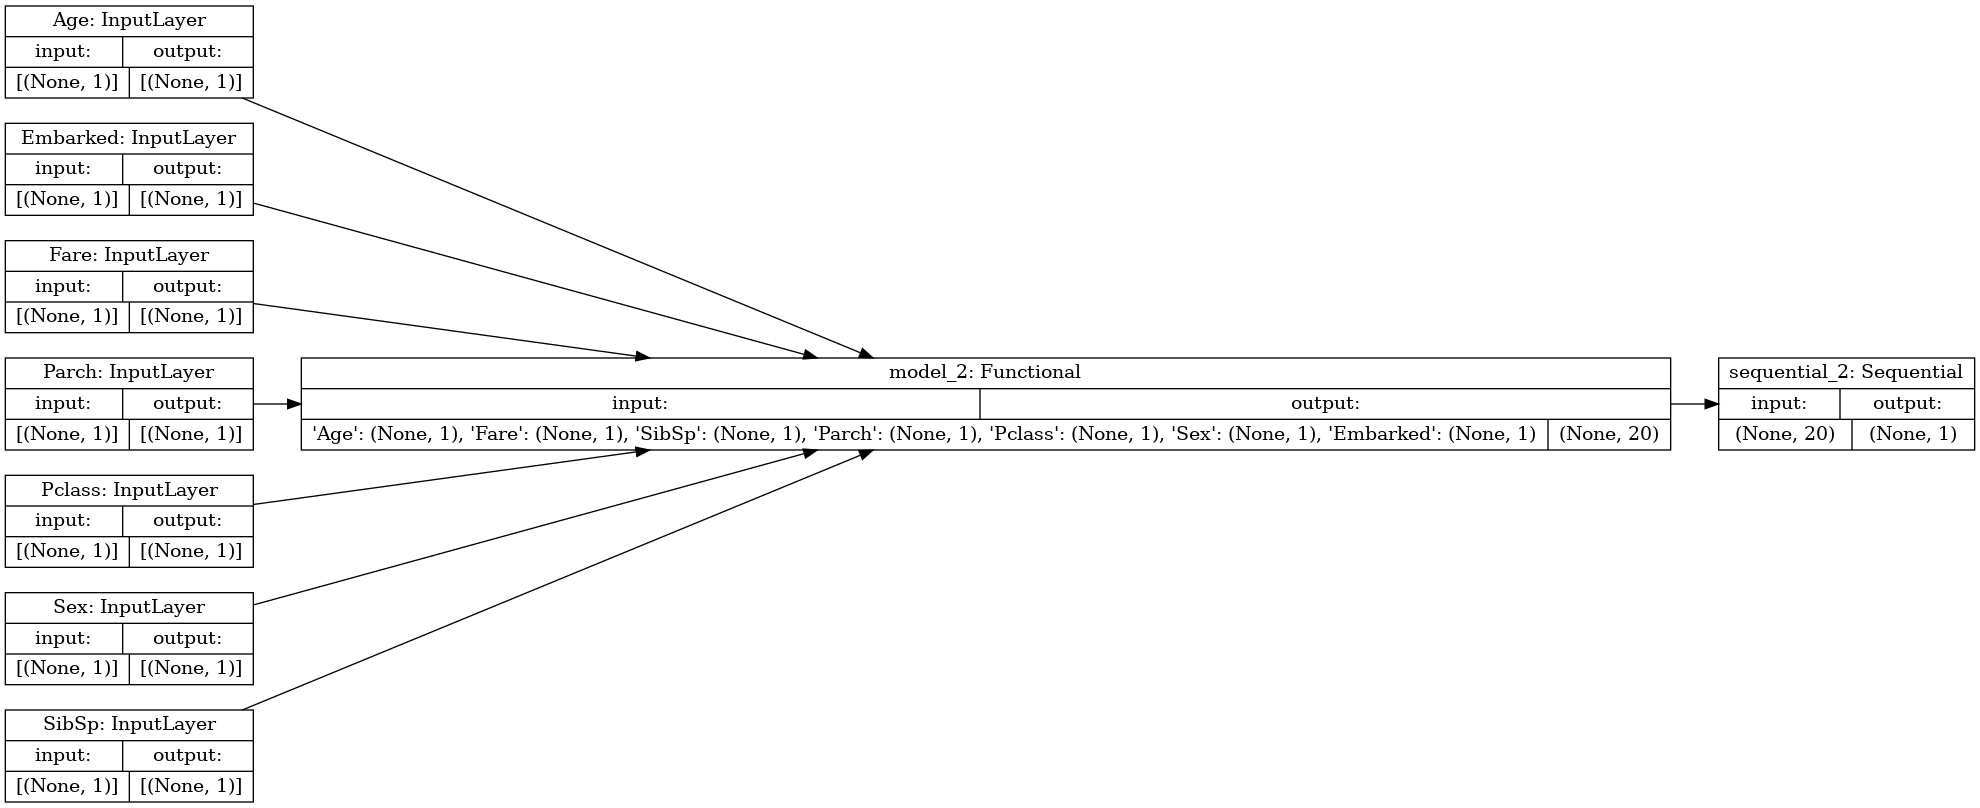

In [11]:
body = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

preprocessed_inputs = preprocess_model(inputs)
result = body(preprocessed_inputs)
model = tf.keras.Model(inputs, result)

model.compile(
    loss=tf.losses.BinaryCrossentropy(),
    # questionable how much Lookahead adds for us here.
    # optimizer=tfa.optimizers.Lookahead(tf.keras.optimizers.Adam()),
    optimizer="adam",
    metrics=["accuracy"],
)


model.summary()

tf.keras.utils.plot_model(
    model,
    to_file="final_model.png",
    rankdir="LR",
    show_shapes=True,
)

In [12]:
model.fit(
    train_features,
    train_labels.to_numpy(),
    shuffle=True,
    batch_size=12,
    validation_freq=10,
    validation_split=0.1,
    verbose=1,
    epochs=600,
)

Epoch 1/600
67/67 [==============================] - 1s 4ms/step - loss: 0.7949 - accuracy: 0.5069
Epoch 2/600
67/67 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.6063

In [7]:
test_predictions = model(test_features)

test_ids = titanic_test_df["PassengerId"].to_numpy()
test_hard_predictions = (
    np.floor(np.array(test_predictions) + 0.5).astype("int").reshape(-1)
)

pred_df = pd.Series(data=test_hard_predictions, name="Survived", index=test_ids)

pred_df.to_csv(
    "prediction.csv",
    index_label="PassengerId",
    header=["Survived"],
)